In [29]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from skorch import NeuralNetClassifier

In [2]:
import umap

In [3]:
!pip install /pstore/home/shetabs1/code/iflai/

Defaulting to user installation because normal site-packages is not writeable
Processing /pstore/home/shetabs1/code/iflai
  Created wheel for iflai: filename=iflai-0.0.1-py3-none-any.whl size=19706 sha256=5e5ee9a56ba0e7ea79dfa7b2d999f1a22248952c0c641b570ab005f5aad8214a
  Stored in directory: /local/2467236/pip-ephem-wheel-cache-pp8b47ky/wheels/77/c9/46/be8aac478e8f67c427d0996a39b13c1213341ddb146b974964
Successfully built iflai
  Attempting uninstall: iflai
    Found existing installation: iflai 0.0.1
    Uninstalling iflai-0.0.1:
      Successfully uninstalled iflai-0.0.1
You should consider upgrading via the '/pstore/apps/Python/3.8.3-2020.07/bin/python -m pip install --upgrade pip' command.


In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import torch
from torchvision import transforms
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset

In [2]:
from sklearn.metrics import classification_report

In [3]:
from imblearn.over_sampling import RandomOverSampler
from iflai.dl.util import read_data, get_statistics_h5, calculate_weights
from iflai.dl.dataset import train_validation_test_split_wth_augmentation, Dataset_Generator_Preprocessed_h5
#from iflai.ml.feature_extractor import AmnisData
from iflai.dl.models import PretrainedModel

In [4]:
from skorch.callbacks import LRScheduler, Checkpoint
import torch.optim as optim
from skorch.helper import predefined_split

In [5]:
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

In [6]:
dataset_name = "wbc"
only_channels = [0,1,2,3,4,5,6,7,8,9,10,11]
path_to_data ="/pstore/data/DS4/White_blood_cell_dataset/Experiment_1/Donor_1/condition_1/"
scaling_factor = 255.
reshape_size = 64
num_channels = len(only_channels)
train_transform = transforms.Compose(
        [transforms.RandomVerticalFlip(),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(45)])
test_transform = transforms.Compose([])
batch_size = 256
num_workers = 2
dev="cuda"

In [7]:
# amnis_data = AmnisData(path_to_data, None)

In [7]:
X, y, CLASS_NAMES, data_map = read_data(path_to_data)

 11%|█         | 3385/31280 [01:32<12:45, 36.45it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/pstore/apps/Python/3.8.3-2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-36277cab50fa>", line 1, in <module>
    X, y, CLASS_NAMES, data_map = read_data(path_to_data)
  File "/pstore/home/shetabs1/.local/lib/python3.8/site-packages/iflai/dl/util.py", line 12, in read_data
    r = h5py.File(os.path.join(path_to_data, image_name), 'r')
  File "/pstore/apps/Python/3.8.3-2020.07/lib/python3.8/site-packages/h5py/_hl/files.py", line 406, in __init__
    fid = make_fid(name, mode, userblock_size,
  File "/pstore/apps/Python/3.8.3-2020.07/lib/python3.8/site-packages/h5py/_hl/files.py", line 173, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 88, in h5

TypeError: object of type 'NoneType' has no len()

In [12]:
num_classes = len(data_map.keys())
train_indx, validation_indx, test_indx = train_validation_test_split_wth_augmentation(X, y, only_classes=None)

In [13]:
train_dataset = Dataset_Generator_Preprocessed_h5(path_to_data=path_to_data,
                                                      set_indx=train_indx,
                                                      scaling_factor=scaling_factor,
                                                      reshape_size=reshape_size,
                                                      transform=train_transform,
                                                      data_map=data_map,
                                                      only_channels=only_channels,
                                                      num_channels=num_channels)

trainloader = DataLoader(train_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=num_workers)

In [14]:
statistics = get_statistics_h5(trainloader, only_channels, None, num_channels)

In [15]:
y_train = [data_map.get(y[i]) for i in train_indx]
weights = calculate_weights(y_train)
class_weights = torch.FloatTensor(weights).to(dev)
oversample = RandomOverSampler(random_state=seed_value, sampling_strategy='all')
train_indx, y_train = oversample.fit_resample(np.asarray(train_indx).reshape(-1, 1), np.asarray(y_train))
train_indx = train_indx.T[0]
y_train = [data_map.get(y[i]) for i in train_indx]
y_test = [data_map.get(y[i]) for i in test_indx]

In [16]:
train_dataset = Dataset_Generator_Preprocessed_h5(path_to_data=path_to_data,
                                                      set_indx=train_indx,
                                                      scaling_factor=scaling_factor,
                                                      reshape_size=reshape_size,
                                                      transform=train_transform,
                                                      data_map=data_map,
                                                      only_channels=only_channels,
                                                      num_channels=num_channels,
                                                      means=statistics["mean"],
                                                      stds=statistics["std"],
                                                  return_only_image=True,
                                                      )

validation_dataset = Dataset_Generator_Preprocessed_h5(path_to_data=path_to_data,
                                                           set_indx=validation_indx,
                                                           scaling_factor=scaling_factor,
                                                           reshape_size=reshape_size,
                                                           transform=test_transform,
                                                           data_map=data_map,
                                                           only_channels=only_channels,
                                                           num_channels=num_channels,
                                                           means=statistics["mean"],
                                                           stds=statistics["std"],
                                                       return_only_image=True,
                                                           )

test_dataset = Dataset_Generator_Preprocessed_h5(path_to_data=path_to_data,
                                                     set_indx=test_indx,
                                                     scaling_factor=scaling_factor,
                                                     reshape_size=reshape_size,
                                                     transform=test_transform,
                                                     data_map=data_map,
                                                     only_channels=only_channels,
                                                     num_channels=num_channels,
                                                     means=statistics["mean"],
                                                     stds=statistics["std"],
                                                 return_only_image=True,
                                                     )

In [17]:
lrscheduler = LRScheduler(policy='StepLR', step_size=7, gamma=0.5)
checkpoint = Checkpoint(f_params='wbs_net_all.pth', monitor='valid_loss_best')

In [23]:
net = NeuralNetClassifier(
    PretrainedModel, 
    criterion=nn.CrossEntropyLoss,
    criterion__weight=class_weights,
    lr=1e-5,
    batch_size=256,
    max_epochs=10,
    module__output_features=num_classes,
    module__num_channels=num_channels, 
    optimizer=optim.Adam,
    iterator_train__shuffle=False,
    iterator_train__num_workers=4,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    callbacks=[lrscheduler, checkpoint],
    train_split=predefined_split(validation_dataset),
    device=dev
)

In [24]:
net.fit(train_dataset, y=None)

  epoch    train_loss    valid_acc    valid_loss    cp      lr       dur
-------  ------------  -----------  ------------  ----  ------  --------
      1        0.5776       0.9683        0.3250     +  0.0000  204.6320
      2        0.1965       0.9758        0.2540     +  0.0000  185.7038
      3        0.1435       0.9800        0.2327     +  0.0000  187.4970
      4        0.1163       0.9814        0.2122     +  0.0000  174.6344
      5        0.0945       0.9835        0.2025     +  0.0000  145.6939
      6        0.0812       0.9827        0.1975     +  0.0000  146.1981
      7        0.0702       0.9843        0.1857     +  0.0000  157.1517
      8        0.0600       0.9861        0.1766     +  0.0000  143.8647
      9        0.0543       0.9864        0.1700     +  0.0000  146.0806
     10        0.0494       0.9856        0.1734        0.0000  143.5976


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PretrainedModel(
    (model): ResNet(
      (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64

In [25]:
y_pred_net = net.predict(test_dataset)

In [39]:
print(classification_report(y_test, y_pred_net, target_names=CLASS_NAMES, digits=4))

              precision    recall  f1-score   support

           0       0.04      0.04      0.04       254
           1       0.60      0.59      0.60      3700
           2       0.03      0.03      0.03       171
           3       0.17      0.16      0.17       927
           4       0.02      0.02      0.02       122
           5       0.07      0.07      0.07       341
           6       0.03      0.03      0.03       214
           7       0.06      0.06      0.06       281
           8       0.04      0.04      0.04       246

    accuracy                           0.39      6256
   macro avg       0.12      0.12      0.12      6256
weighted avg       0.39      0.39      0.39      6256



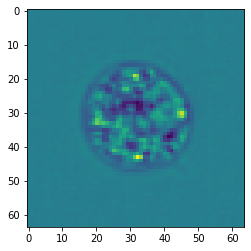

In [38]:
plt.imshow(test_dataset[3][0][0,:,:])